# TRGAN


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

import torch
from torch import optim
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.special import rel_entr, kl_div
from scipy.spatial.distance import jensenshannon
from scipy.stats import kstest, ks_2samp, wasserstein_distance
import scipy.stats as sts
from tqdm import tqdm

from TRGAN.embedder import CategoricalEmbedder, AutoEncoderContinuosEmbedder, ClientEmbedder
from TRGAN.feature_extractor import FeatureExtractor, FeatureExtractorConfig
from TRGAN.embedder import AutoEncoderConfig
from TRGAN.TRGAN import TRGAN, TRGANConfig, TRGANDataset
from TRGAN.dataset.catalog import get_dataset
import warnings
from TRGAN.time_generation import synthetic_deltas
from TRGAN.comparison import compare_amount
from TRGAN.comparison import compare_categorical
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

/home/llorenti/venvs/general/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/llorenti/venvs/general/lib64/python3.9/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


### Import data

In [3]:

data, metadata = get_dataset("uk_bank")

data_wrapped = TRGANDataset(
    data, 
    metadata,
    n_splits=4
)

 58%|█████▊    | 2922/5000 [01:04<00:45, 45.81it/s]

# Time deltas comparison

Text(0.5, 1.0, 'Distribution of time between two transactions')

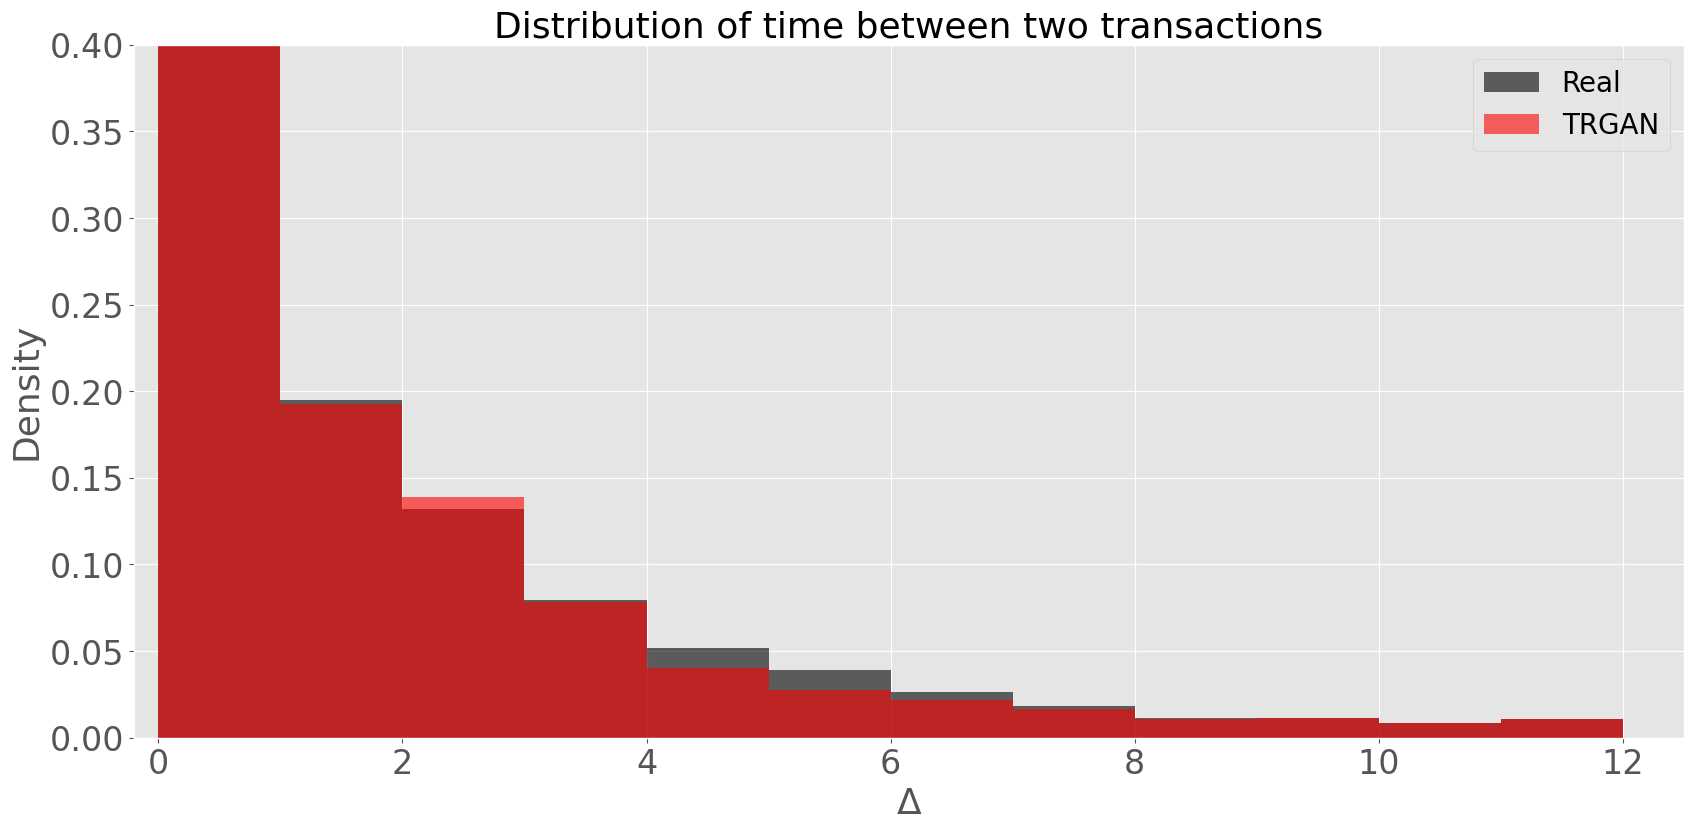

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(20, 9), dpi=100)
axs.hist(
    np.concatenate(data_wrapped.deltas.values),
    alpha=0.6,
    bins=np.arange(-1, 12) + 1,
    label="Real",
    density=True,
    color="black",
)
axs.hist(
    synthetic_deltas(data_wrapped),
    alpha=0.6,
    bins=np.arange(-1, 12) + 1,
    label="TRGAN",
    density=True,
    color="red",
)

axs.legend(fontsize=20)
axs.set_xlabel("$\Delta$", fontsize=26)
axs.set_ylabel("Density", fontsize=26)
axs.tick_params(labelsize=24)
axs.locator_params(axis="x", integer=True)
axs.set_ylim((0, 0.4))
axs.set_xlim((-0.2, 12.5))
axs.set_title("Distribution of time between two transactions", fontsize=26)


In [5]:

from TRGAN.feature_extractor import default_feature_extractor_config


model = TRGAN(
    metadata=metadata,
    config= TRGANConfig(
        num_epochs=30,
        feature_extraction =  default_feature_extractor_config(20)
    ),
    device="cpu"
)
model.train_extractor(data_wrapped)


  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (AutoEncoderConfig(dimension=30, learning_rate=5e-05, batch_size=64, epochs=20, eps=0.01, differential_privacy_sensitivity=300.0, differential_privacy=True), 0.1)-Differential Privacy


  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (AutoEncoderConfig(dimension=12, learning_rate=0.0008, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (AutoEncoderConfig(dimension=4, learning_rate=0.001, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


  0%|          | 0/20 [00:00<?, ?it/s]

E_oh with (AutoEncoderConfig(dimension=10, learning_rate=0.001, batch_size=128, epochs=20, eps=0.01, differential_privacy_sensitivity=4, differential_privacy=True), 0.1)-Differential Privacy


Loss Condition vector embedder: 0.000020497 : 100%|██████████| 20/20 [00:42<00:00,  2.14s/it]


# validating the autoencoder

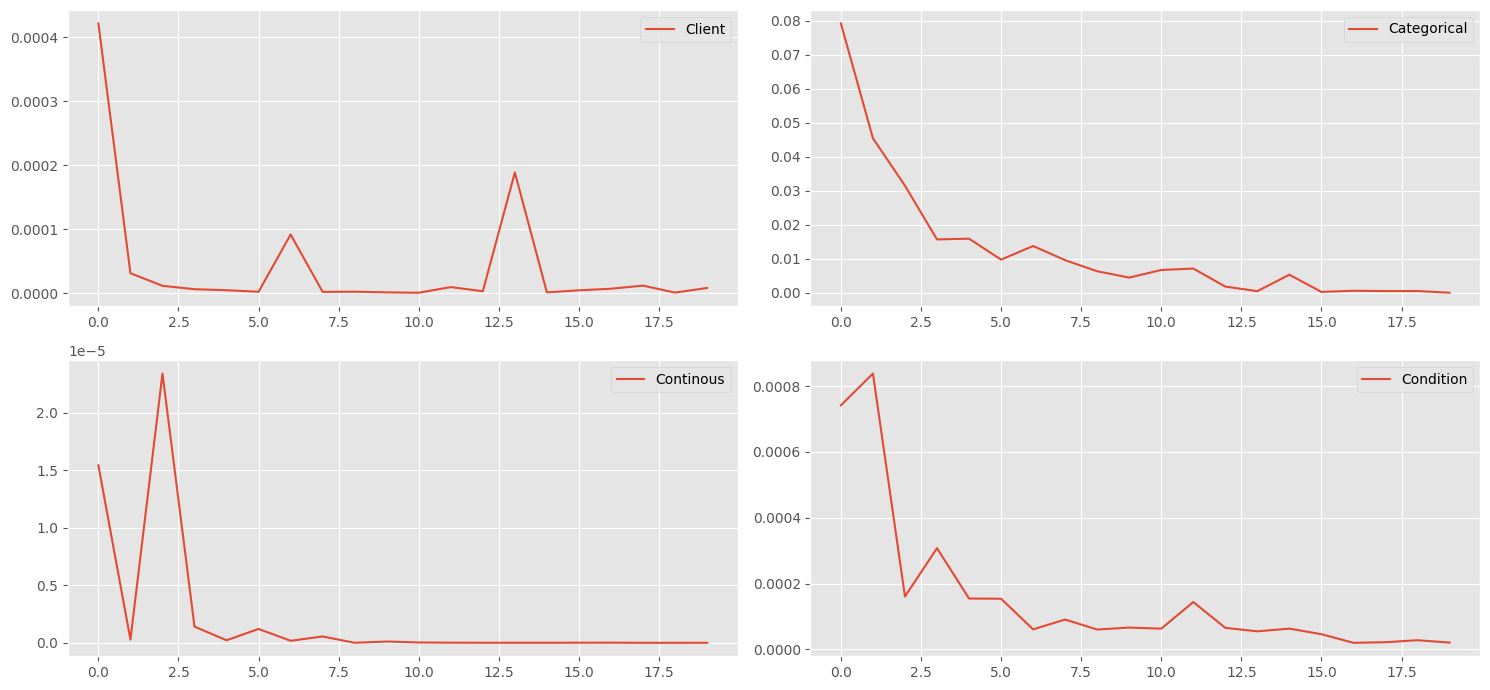

In [7]:
fig, ax = plt.subplots(2,2, figsize=(15, 7))
ax[0,0].plot(model.feature_extractor.client_embedder.history, label="Client")
ax[0,1].plot(model.feature_extractor.categorical_embedder.history,label="Categorical")
ax[1,0].plot(model.feature_extractor.continous_embedder.history, label="Continous")
ax[1,1].plot(model.feature_extractor.condition_vector_embedded.history, label="Condition")
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
fig.tight_layout()

<Axes: title={'center': 'Numerical distribution of the amount'}, xlabel='Amount', ylabel='Density'>

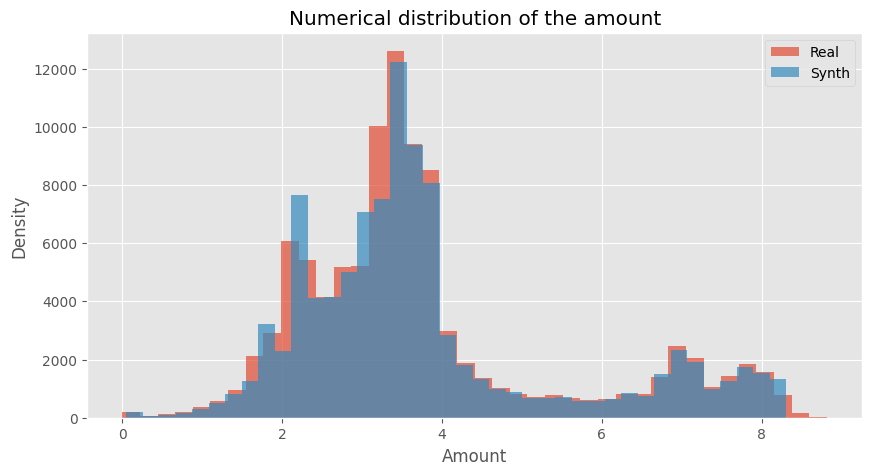

In [8]:
continous_embedder = model.feature_extractor.continous_embedder
rr = continous_embedder.inverse_transform(
    continous_embedder.encode(
        data[["amount"]]
    )
)

compare_amount(data.amount, rr.amount)


0.98761

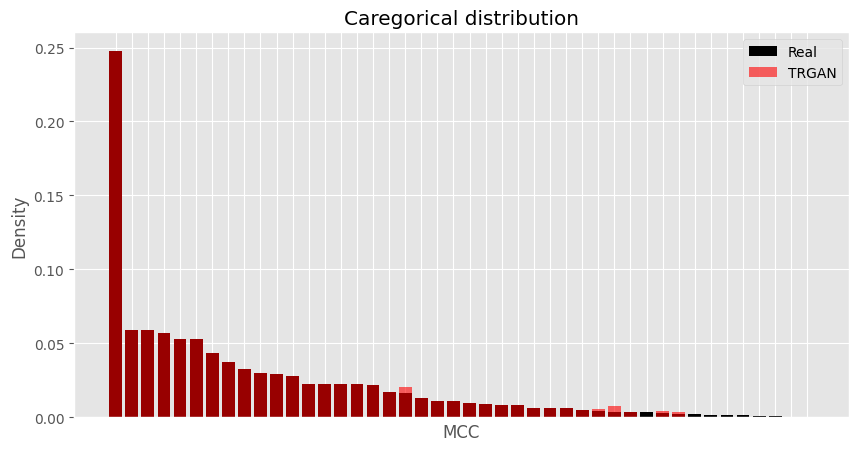

In [9]:
categorical_embedder = model.feature_extractor.categorical_embedder
qq = categorical_embedder.inverse_transform(
    categorical_embedder.encode(
        data[["mcc"]]
    )
)

compare_categorical(data.mcc, qq.mcc)
df_cat = pd.concat([data.mcc, qq.mcc], axis=1)
df_cat.columns = ["real", "synthetic"]
(df_cat["real"].astype("str") == df_cat["synthetic"].astype("str")).mean()

In [11]:
model.build_GAN()
model.train_GAN(data_wrapped)

Discriminator Loss: -0.00000 || Discriminator 2 Loss: -0.00000 || Generator Loss: 0.00062 || Supervisor Loss: -0.00051:  97%|█████████▋| 29/30 [20:30<00:42, 42.45s/it]

nan
nan
nan
nan


model.train_GAN(data_wrapped)

[autoreload of TRGAN.dataset.metadata failed: Traceback (most recent call last):
  File "/home/llorenti/venvs/general/lib64/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/llorenti/venvs/general/lib64/python3.9/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/llorenti/venvs/general/lib64/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/llorenti/venvs/general/lib64/python3.9/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/llorenti/venvs/general/lib64/python3.9/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/llorenti/venvs/general/lib64/python3.9/site-packages/IPython/extensions/autoreload.py", line 309, in update_func

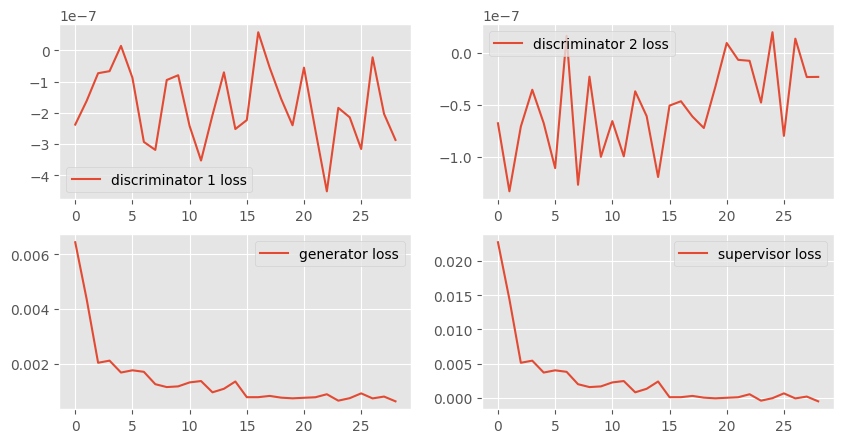

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5), dpi=100)

axs[0, 0].plot(np.array(model.loss_array).T[0], label='discriminator 1 loss')
axs[0, 1].plot(np.array(model.loss_array).T[1], label='discriminator 2 loss')
axs[1, 0].plot(np.array(model.loss_array).T[2], label='generator loss')
axs[1, 1].plot(np.array(model.loss_array).T[3], label='supervisor loss')

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()
plt.show()

In [9]:
import pickle
with open("data.pkl", "wb") as file:
    pickle.dump(model, file)

In [10]:
import pickle
with open("data.pkl", "rb") as file:
    model = pickle.load(file)

In [11]:
rr = model.sample(data_wrapped, 100000).rename(columns={'date': 'transaction_date'})

<Axes: title={'center': 'Numerical distribution of the amount'}, xlabel='Amount', ylabel='Density'>

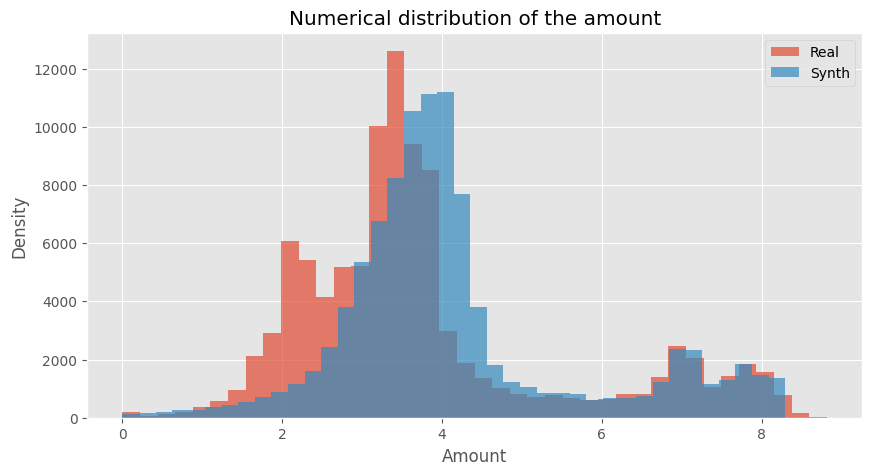

In [12]:
compare_amount(data.amount, rr.amount)


(array([  470.,  2848., 13409., 23618., 16258.,  2548.,  1429.,  3758.,
         4528.,  1794.]),
 array([0.        , 0.88167791, 1.76335583, 2.64503374, 3.52671165,
        4.40838957, 5.29006748, 6.17174539, 7.0534233 , 7.93510122,
        8.81677913]),
 <BarContainer object of 10 artists>)

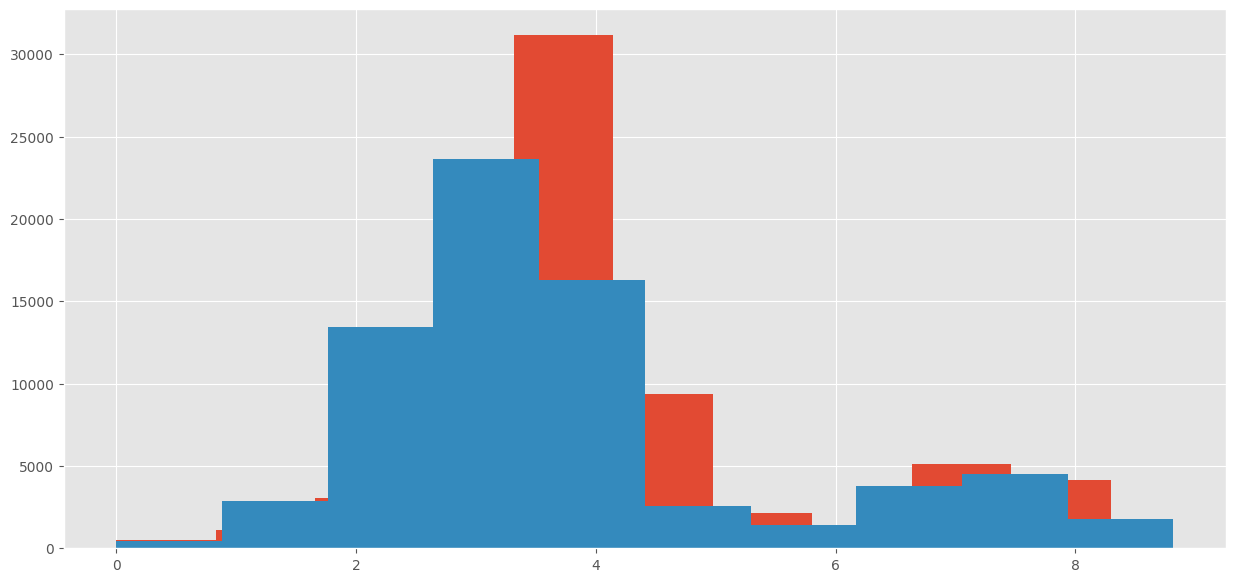

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))


ax.hist(np.log1p(np.abs(list(rr.groupby(rr.transaction_date.dt.month).amount)[0][1])))

ax.hist(np.log1p(np.abs(list(data.groupby(rr.transaction_date.dt.month).amount)[0][1])))



## Quality Assessment

In [13]:
synth_data, synth_time = model.sample_embedding(data_wrapped, 100000)
X_emb = model.feature_extractor.embed(data)

In [14]:
X_gr = []
X_gr.append(X_emb[:, :21].T[:7])
X_gr.append(X_emb[:, :21].T[7:14])
X_gr.append(X_emb[:, :21].T[14:21])
X_gr = np.array(X_gr)

X_gr_s = []
X_gr_s.append(synth_data[:, :21].T[:7])
X_gr_s.append(synth_data[:, :21].T[7:14])
X_gr_s.append(synth_data[:, :21].T[14:21])
X_gr_s = np.array(X_gr_s)

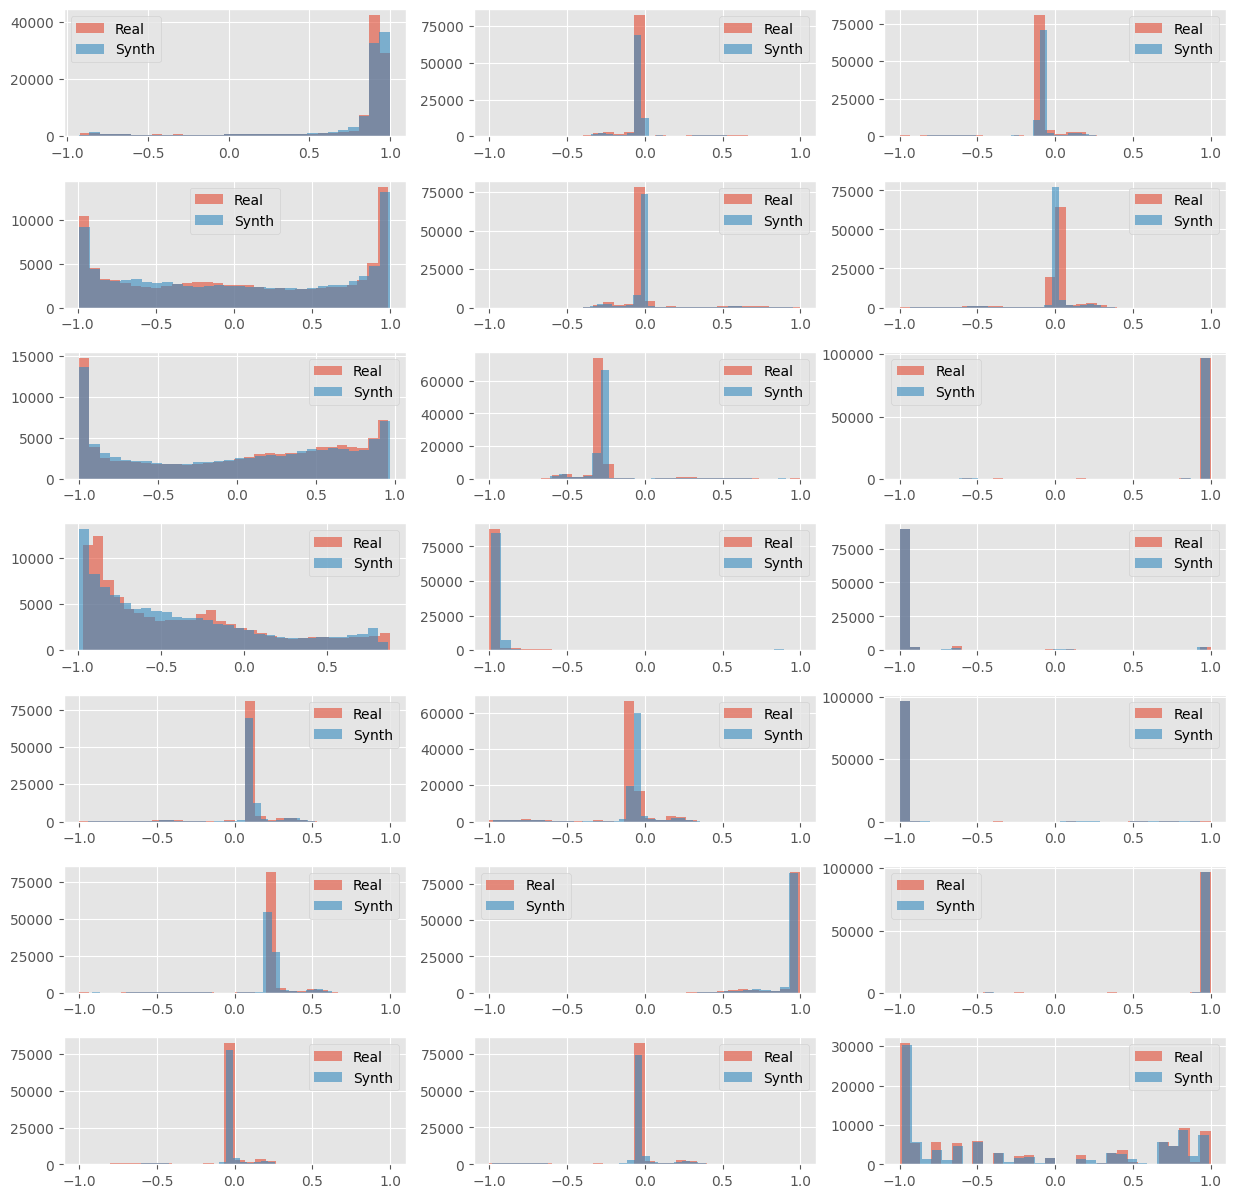

In [15]:
fig, axs = plt.subplots(7, 3, figsize=(15, 15), dpi=100)

for i in range(7):
    for j in range(3):
        axs[i, j].hist(X_gr[j, i], bins=30, label='Real', alpha=0.6)
        axs[i, j].hist(X_gr_s[j, i], bins=30, label='Synth', alpha=0.6)

        axs[i, j].legend()

plt.subplots_adjust(hspace=0.35)
# plt.savefig('results_synth_exp4.png', dpi=300)
plt.show()

### Compare mcc

<Axes: title={'center': 'Caregorical distribution'}, xlabel='MCC', ylabel='Density'>

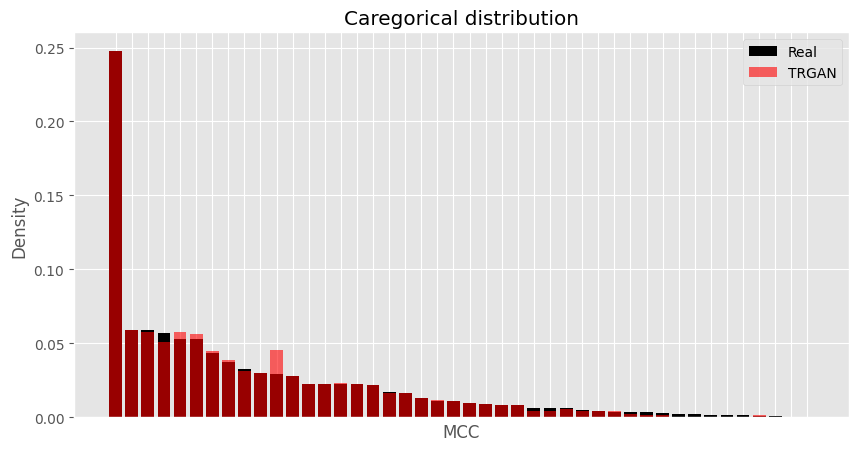

In [16]:

compare_categorical(
    data.mcc,
    rr.mcc
)

In [ ]:
from TRGAN.evaluation_metrics import evaluate_categorical
rr["mcc"] = rr["mcc"].astype("int")
evaluate_categorical(
    data_array=[
        data['mcc'], 
        rr['mcc']
    ], 
    index=['Real', 'TRGAN'], 
    data_cont_array=[
        data[['mcc', 'transaction_date']], 
        rr[['mcc', 'transaction_date']]
    ])

In [37]:
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')


metadata.add_column(
    column_name='customer',
    sdtype='categorical')


metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

In [43]:
from sdmetrics.single_table import NewRowSynthesis

NewRowSynthesis.compute(
    # real_data=data.drop('index', axis=1),
    real_data=data,
    synthetic_data=rr,
    metadata=metadata,
    numerical_match_tolerance=0.01,
    synthetic_sample_size=10_000
)

0.9795

### Compare clients' features

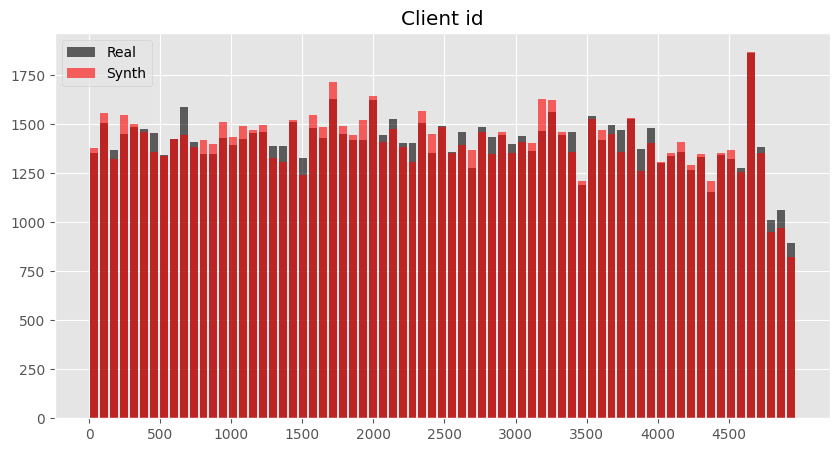

In [41]:
fig, axs = plt.subplots(figsize=(10, 5), dpi=100)

plt.hist(
    data["customer"],
    alpha=0.6,
    label="Real",
    bins=np.arange(0, 5000, 70),
    color="black",
    rwidth=0.8,
)
plt.hist(
    rr["customer"],
    alpha=0.6,
    label="Synth",
    bins=np.arange(0, 5000, 70),
    color="red",
    rwidth=0.8,
)

plt.legend()
plt.xticks(
    np.arange(0, len(data["customer"].value_counts()), 500),
    np.arange(0, len(data["customer"].value_counts()), 500),
)
plt.title("Client id")

plt.show()

In [54]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca1 = PCA(n_components=2)
# pca2 = PCA(n_components=2)

X_oh = model.feature_extractor.categorical_embedder.encode(data[["mcc"]])
synth_df_cat = model.feature_extractor.categorical_embedder.encode(rr[["mcc"]])
data_transformed_pca = pca1.fit_transform(X_oh)
synth_pca = pca1.transform(synth_df_cat)
# data_transformed_pca = pca1.fit_transform(X_emb)
# synth_pca = pca2.fit_transform(synth_data)

tsne1 = TSNE(n_components=2, perplexity=80)
tsne2 = TSNE(n_components=2, perplexity=80)

idx_random = np.random.randint(0, len(X_emb), 5000)

data_transformed_tsne = tsne1.fit_transform(X_emb[idx_random])
synth_tsne = tsne2.fit_transform(synth_data[idx_random])


figure, axs = plt.subplots(1, 2, figsize=(15, 5), dpi=100)

axs[0].scatter(
    data_transformed_pca.T[0], data_transformed_pca.T[1], label="Real", alpha=0.4, s=20
)
axs[0].scatter(synth_pca.T[0], synth_pca.T[1], label="Synth", alpha=0.4, s=10)

axs[0].legend()
axs[0].set_xlabel("$X_1$")
axs[0].set_ylabel("$X_2$")
axs[0].set_title("PCA")


axs[1].scatter(
    data_transformed_tsne.T[0], data_transformed_tsne.T[1], label="Real", s=3, alpha=1
)
axs[1].scatter(synth_tsne.T[0], synth_tsne.T[1], label="Synth", s=3, alpha=1)

axs[1].legend()
axs[1].set_xlabel("$X_1$")
axs[1].set_ylabel("$X_2$")
axs[1].set_title("t-SNE")

plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100000x38 and 44x64)

## Comparison with other models

Prepare metadata for methods

In [ ]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.add_column(
    column_name='amount',
    sdtype='numerical',
    computer_representation='Float')

metadata.add_column(
    column_name='mcc',
    sdtype='categorical')

metadata.add_column(
    column_name='transaction_date',
    sdtype='datetime',
    datetime_format='%Y %m %d')

Choose categorical columns for metrics calculation

In [ ]:
cat_columns = ['mcc']

### Compare categorical columns

In [ ]:
def copulagan(data: pd.DataFrame, metadata, cat_columns=['mcc'], epochs=10, n_samples=10_000, load=False):
    
    if load:
        synthesizer = CopulaGANSynthesizer(metadata, epochs=epochs)
        synthesizer = synthesizer.load(f'{DIRECTORY}CopulaGAN_uk2.pkl')
    else:
        synthesizer = CopulaGANSynthesizer(metadata, epochs=epochs)
        synthesizer.fit(data)
        synthesizer.save(f'{DIRECTORY}CopulaGAN_uk2.pkl')

    synth_copulagan = synthesizer.sample(num_rows=n_samples)

    synth_df_cat_copulagan = pd.get_dummies(synth_copulagan[cat_columns], columns=cat_columns)

    return synth_copulagan, synth_df_cat_copulagan

def ctgan(data: pd.DataFrame, metadata, cat_columns=['mcc'], epochs=10, n_samples=10_000, load=False):

    if load:
        synthesizer = CTGANSynthesizer(metadata, epochs=epochs)
        synthesizer = synthesizer.load(f'{DIRECTORY}CTGAN_uk2.pkl')
    else:
        synthesizer = CTGANSynthesizer(metadata, epochs=epochs)
        synthesizer.fit(data)
        synthesizer.save(f'{DIRECTORY}CTGAN_uk2.pkl')
 
    synth_ctgan = synthesizer.sample(num_rows=n_samples)

    synth_df_cat_ctgan = pd.get_dummies(synth_ctgan[cat_columns], columns=cat_columns)

    return synth_ctgan, synth_df_cat_ctgan

def compare_categorical_w_banksformer(data, synth_df, synth_df_cat, X_oh, metadata, cat_columns, synth_banks,\
                                    epochs=2, n_samples=10_000, comp_col='mcc', contig_cols=['mcc', 'customer'], load=False):
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

    axs[0, 0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[0, 0].bar(np.sort(synth_df['mcc'].value_counts().index.values).astype(str),\
            synth_df['mcc'].value_counts().values/np.sum(synth_df['mcc'].value_counts().values), color='red', alpha=0.6, label='TRGAN')
    
    # axs[0, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=13)
    axs[0, 0].tick_params(axis='y', labelsize=20)
    axs[0, 0].legend(fontsize=18)
    axs[0, 0].set_xlabel('Category', fontsize=22)
    axs[0, 0].set_ylabel('Density', fontsize=22)
#     axs[0, 0].set_title('TRGAN')


    axs[0, 1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[0, 1].bar(np.sort(synth_ctgan['mcc'].value_counts().index.values).astype(str),\
            synth_ctgan['mcc'].value_counts().values/np.sum(synth_ctgan['mcc'].value_counts().values), color='lightblue', alpha=0.6, label='CTGAN')

    # axs[0, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[0, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[0, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=13)
    axs[0, 1].tick_params(axis='y', labelsize=20)
    axs[0, 1].legend(fontsize=18)
    axs[0, 1].set_xlabel('Category', fontsize=22)
    # axs[0, 1].set_ylabel('Density', fontsize=16)
#     axs[0, 1].set_title('CTGAN')


    axs[1, 0].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[1, 0].bar(np.sort(synth_copulagan['mcc'].value_counts().index.values).astype(str),\
            synth_copulagan['mcc'].value_counts().values/np.sum(synth_copulagan['mcc'].value_counts().values), color='orange', alpha=0.6, label='CopulaGAN')

    # axs[1, 0].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[1, 0].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[1, 0].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=13)
    axs[1, 0].tick_params(axis='y', labelsize=20)
    axs[1, 0].legend(fontsize=18)
    axs[1, 0].set_xlabel('Category', fontsize=22)
    axs[1, 0].set_ylabel('Density', fontsize=22)
#     axs[1, 0].set_title('CopulaGAN')

    
    axs[1, 1].bar(np.sort(data['mcc'].value_counts().index.values).astype(str),\
            data['mcc'].value_counts().values/np.sum(data['mcc'].value_counts().values), color='black', alpha=0.6, label='Real')
    axs[1, 1].bar(np.sort(synth_banksformer['mcc'].value_counts().index.values).astype(str),\
            synth_banksformer['mcc'].value_counts().values/np.sum(synth_banksformer['mcc'].value_counts().values), color='green', alpha=0.6, label='Banksformer')
    
    # axs[1, 1].set_xticks(data['mcc'].value_counts().index.values.astype(str)[::2])
    # axs[1, 1].set_xticklabels(data['mcc'].value_counts().index.values.astype(str)[::2], rotation=45)
    axs[1, 1].tick_params(axis='x', which='both', bottom=False, labelbottom=False, labelsize=13)
    axs[1, 1].tick_params(axis='y', labelsize=20)
    axs[1, 1].legend(fontsize=18)
    axs[1, 1].set_xlabel('Category', fontsize=22)
    # axs[1, 1].set_ylabel('Density', fontsize=16)
#     axs[1, 1].set_title('Banksformer')

    plt.subplots_adjust(hspace=0.15, wspace=0.12)
    plt.tight_layout(pad=0.5)
    plt.savefig('synth_mcc_uk.pdf', dpi=300)
    plt.show()

    # display(evaluate_new_rows([data, synth_df, synth_ctgan, synth_copulagan, synth_banksformer],\
                # index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'], metadata=metadata))

    eval_cat = evaluate_categorical([data[comp_col], synth_df[comp_col], synth_ctgan[comp_col], synth_copulagan[comp_col], synth_banksformer[comp_col]],\
                                     index=['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'],\
    data_cont_array=[data[contig_cols], synth_df[contig_cols], synth_ctgan[contig_cols], synth_copulagan[contig_cols], synth_banksformer[contig_cols]])

    return eval_cat

In [ ]:
compare_categorical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df[['mcc', 'amount', 'transaction_date']], synth_df_cat, X_oh, metadata, \
            cat_columns, synth_banksformer.sample(len(data))[['mcc', 'amount', 'transaction_date']],\
            epochs=3, n_samples=len(data), comp_col='mcc', contig_cols=['mcc', 'transaction_date'], load=True)

NameError: name 'synth_df' is not defined

### Compare numerical columns

In [ ]:
def compare_numerical_w_banksformer(data, synth_df, metadata, cat_columns, synth_banks, epochs=10, n_samples=10_000,\
                                    comp_col='amount', load=False, type_comp='log_amount', data_customer=''):
    
    """_summary_

    Returns:
       Object: Return graphs and table with metrics

    Types of visuals:
        - Log amount: log_amount
        - Cash flow: cash_flow

    """
    synth_copulagan, synth_copulagan_cat = copulagan(data, metadata, cat_columns, epochs, n_samples, load)
    synth_ctgan, synth_ctgan_cat = ctgan(data, metadata, cat_columns, epochs, n_samples, load)
    # synth_tvae, synth_tvae_cat = tvae(data, metadata, cat_columns, epochs, n_samples, load)
    synth_banksformer = synth_banks

    if type_comp == 'log_amount':

        data = copy.deepcopy(data)
        synth_df = copy.deepcopy(synth_df)
        data[comp_col] = abs(data[comp_col])
        synth_df[comp_col] = abs(synth_df[comp_col])
        synth_ctgan[comp_col] = abs(synth_ctgan[comp_col])
        synth_copulagan[comp_col] = abs(synth_copulagan[comp_col])
        synth_banksformer[comp_col] = abs(synth_banksformer[comp_col])

        hist_real = np.histogram(np.log1p(data[comp_col]), normed=True, bins=40)

        fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

        axs[0, 0].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 0].hist(np.log1p(synth_df[comp_col]), bins=40, label='TRGAN', alpha=0.7, density=True, color='red')
        axs[0, 0].legend(fontsize=18)
        axs[0, 0].set_xlabel('Log amount', fontsize=22)
        axs[0, 0].set_ylabel('Density', fontsize=22)
        axs[0, 0].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[0, 0].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        axs[0, 0].tick_params(labelsize=20)
        # axs[0, 0].set_title('TRGAN')

        axs[0, 1].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 1].hist(np.log1p(synth_ctgan[comp_col]), bins=40, label='CTGAN', alpha=0.7, density=True, color='lightblue')
        axs[0, 1].legend(fontsize=18)
        axs[0, 1].set_xlabel('Log amount', fontsize=22)
        # axs[0, 1].set_ylabel('Density', fontsize=16)
        axs[0, 1].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[0, 1].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        axs[0, 1].tick_params(labelsize=20)
        # axs[0, 1].set_title('CTGAN')

        axs[1, 0].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 0].hist(np.log1p(synth_copulagan[comp_col]), bins=40, label='CopulaGAN', alpha=0.7, density=True, color='orange')
        axs[1, 0].legend(fontsize=18)
        axs[1, 0].set_xlabel('Log amount', fontsize=22)
        axs[1, 0].set_ylabel('Density', fontsize=22)
        axs[1, 0].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[1, 0].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        axs[1, 0].tick_params(labelsize=20)
        # axs[1, 0].set_title('CopulaGAN')

        axs[1, 1].hist(np.log1p(data[comp_col]), bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 1].hist(np.log1p(synth_banksformer[comp_col]), bins=40, label='Banksformer', alpha=0.7, density=True, color='green')
        axs[1, 1].legend(fontsize=18)
        axs[1, 1].set_xlabel('Log amount', fontsize=22)
        # axs[1, 1].set_ylabel('Density', fontsize=16)
        axs[1, 1].set_xlim((-0.5, np.max(hist_real[1]) + 1e-2))
        axs[1, 1].set_ylim((0, np.max(hist_real[0]) + 1e-2))
        axs[1, 1].tick_params(labelsize=20)
        # axs[1, 1].set_title('Banksformer')

        plt.subplots_adjust(hspace=0.25, wspace=0.12)
        plt.tight_layout(pad=0.5)
        plt.savefig('synth_amount_uk.pdf', dpi=300)
        plt.show()

        eval_num = evaluate_numerical([np.log1p(data[comp_col]), np.log1p(synth_df[comp_col]), np.log1p(synth_ctgan[comp_col]),\
                                       np.log1p(synth_copulagan[comp_col]), np.log1p(synth_banksformer[comp_col])],\
                    ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'])
        
        return eval_num
    
    elif type_comp == 'cash_flow':

        data = copy.deepcopy(data)
        synth_df = copy.deepcopy(synth_df)
        data['month'] = data['transaction_date'].dt.month
        synth_banksformer['month'] = synth_banksformer['transaction_date'].dt.month
        synth_df['month'] = synth_df['transaction_date'].dt.month
        synth_ctgan['month'] = synth_ctgan['transaction_date'].dt.month
        synth_copulagan['month'] = synth_copulagan['transaction_date'].dt.month
        # synth_tvae['month'] = synth_tvae['transaction_date'].dt.month

        data = pd.concat([data, data_customer], axis=1)
        synth_ctgan = pd.concat([synth_ctgan, data_customer], axis=1)
        synth_copulagan = pd.concat([synth_copulagan, data_customer], axis=1)

        
        cash_flow_real = (data.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_banks = (synth_banksformer.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_trgan = (synth_df.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_ctgan = (synth_ctgan.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()
        cash_flow_copulagan = (synth_copulagan.groupby(by=['customer', 'month'])['amount'].apply(lambda x: x - x.shift())).dropna()

        q = np.quantile(cash_flow_real, 0.95)

        cash_flow_real = cash_flow_real.iloc[np.where((cash_flow_real <= q) & (cash_flow_real >= -q))[0]]
        cash_flow_banks = cash_flow_banks.iloc[np.where((cash_flow_banks <= q) & (cash_flow_banks >= -q))[0]]
        cash_flow_trgan = cash_flow_trgan.iloc[np.where((cash_flow_trgan <= q) & (cash_flow_trgan >= -q))[0]]
        cash_flow_ctgan = cash_flow_ctgan.iloc[np.where((cash_flow_ctgan <= q) & (cash_flow_ctgan >= -q))[0]]
        cash_flow_copulagan = cash_flow_copulagan.iloc[np.where((cash_flow_copulagan <= q) & (cash_flow_copulagan >= -q))[0]]
        
        min_length = np.min(list(map(lambda x: len(x), [cash_flow_real, cash_flow_trgan, cash_flow_banks, cash_flow_ctgan, cash_flow_copulagan])))

        cash_flow_real = pd.Series(random.sample(cash_flow_real.values.tolist(), min_length))
        cash_flow_banks = pd.Series(random.sample(cash_flow_banks.values.tolist(), min_length))
        cash_flow_trgan = pd.Series(random.sample(cash_flow_trgan.values.tolist(), min_length))
        cash_flow_ctgan = pd.Series(random.sample(cash_flow_ctgan.values.tolist(), min_length))
        cash_flow_copulagan = pd.Series(random.sample(cash_flow_copulagan.values.tolist(), min_length))

        hist_real = np.histogram(cash_flow_real, normed=True, bins=40)

        fig, axs = plt.subplots(2, 2, figsize=(20, 10), dpi=100)

        axs[0, 0].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 0].hist(cash_flow_trgan, bins=40, label='TRGAN', alpha=0.7, density=True, color='red')
        axs[0, 0].legend(fontsize=18)
        axs[0, 0].set_xlabel('Monthly cash flow', fontsize=22)
        axs[0, 0].set_ylabel('Density', fontsize=22)
        axs[0, 0].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[0, 0].set_ylim((0, np.max(hist_real[0]) + 3e-4))
        axs[0, 0].tick_params(labelsize=20)
        # axs[0, 0].set_title('TRGAN')

        axs[0, 1].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[0, 1].hist(cash_flow_ctgan, bins=40, label='CTGAN', alpha=0.7, density=True, color='lightblue')
        axs[0, 1].legend(fontsize=18)
        axs[0, 1].set_xlabel('Monthly cash flow', fontsize=22)
        # axs[0, 1].set_ylabel('Density', fontsize=16)
        axs[0, 1].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[0, 1].set_ylim((0, np.max(hist_real[0]) + 3e-4))
        axs[0, 1].tick_params(labelsize=20)
        # axs[0, 1].set_title('CTGAN')

        axs[1, 0].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 0].hist(cash_flow_copulagan, bins=40, label='CopulaGAN', alpha=0.7, density=True, color='orange')
        axs[1, 0].legend(fontsize=18)
        axs[1, 0].set_xlabel('Monthly cash flow', fontsize=22)
        axs[1, 0].set_ylabel('Density', fontsize=22)
        axs[1, 0].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[1, 0].set_ylim((0, np.max(hist_real[0]) + 3e-4))
        axs[1, 0].tick_params(labelsize=20)
        # axs[1, 0].set_title('CopulaGAN')

        axs[1, 1].hist(cash_flow_real, bins=40, label='Real', alpha=0.7, density=True, color='black')
        axs[1, 1].hist(cash_flow_banks, bins=40, label='Banksformer', alpha=0.7, density=True, color='green')
        axs[1, 1].legend(fontsize=18)
        axs[1, 1].set_xlabel('Monthly cash flow', fontsize=22)
        # axs[1, 1].set_ylabel('Density', fontsize=16)
        axs[1, 1].set_xlim((-np.max(hist_real[1]), np.max(hist_real[1])))
        axs[1, 1].set_ylim((0, np.max(hist_real[0]) + 3e-4))
        axs[1, 1].tick_params(labelsize=20)
        # axs[1, 1].set_title('Banksformer')

        plt.subplots_adjust(hspace=0.25, wspace=0.15)
        plt.tight_layout(pad=0.5)
        plt.savefig('synth_cashflow_uk.pdf', dpi=300)
        plt.show()

        eval_num = evaluate_numerical_cashflow([cash_flow_real, cash_flow_trgan, cash_flow_ctgan, cash_flow_copulagan, cash_flow_banks],\
                    ['Real', 'TRGAN', 'CTGAN', 'CopulaGAN', 'Banksformer'])
        
        return eval_num
    
    else:
        print('Choose the type of comparison')

In [ ]:
compare_numerical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df, metadata, cat_columns,\
                                synth_banksformer.sample(len(data)), epochs=5, n_samples=len(data), comp_col='amount',\
                                load=True, type_comp='log_amount', data_customer=data[['customer']])

NameError: name 'synth_df' is not defined

In [ ]:
compare_numerical_w_banksformer(data[['mcc', 'amount', 'transaction_date']], synth_df, metadata, cat_columns,\
                                synth_banksformer.sample(len(data)), epochs=5, n_samples=len(data), comp_col='amount',\
                                load=True, type_comp='cash_flow', data_customer=data[['customer']])

In [ ]:
compare_categorical_w_banksformer_3grams(data, synth_df, synth_banksformer)

In [ ]:
# synth_df.to_csv(f'Synthetic_data_{experiment_id}.csv', index=False)